In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load dataset from gdrive

!cp ./drive/MyDrive/ICNA_hackathon/* ./
!unzip FordA.zip

In [ ]:
import numpy as np
from helper import Helper
helper = Helper()

file_train = "./FordA/FordA_TRAIN.ts"
file_test = "./FordA/FordA_TEST.ts"
x_train, y_train = helper.data_processing(file_train)
x_test, y_test = helper.data_processing(file_test)

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [ ]:
print(x_train.shape)
print(y_train.shape)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [ ]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


## Train and evaluate

In [ ]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)


checkpoint_path = "./transformer_ba"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    model="min",
    verbose=0,
    save_best_only=True,
)

model = keras.models.load_model("./transformer_ba")
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["binary_accuracy"],
)
model.summary()

early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 500, 1)      2           ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 500, 1)      7169        ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

INFO:tensorflow:Assets written to: ./transformer_ba/assets


INFO:tensorflow:Assets written to: ./transformer_ba/assets


51/51 [==============================] - 27s 438ms/step - loss: 0.2031 - binary_accuracy: 0.9256 - val_loss: 0.3825 - val_binary_accuracy: 0.8449
Epoch 2/200
51/51 [==============================] - 15s 286ms/step - loss: 0.1949 - binary_accuracy: 0.9306 - val_loss: 0.3842 - val_binary_accuracy: 0.8449
Epoch 3/200
51/51 [==============================] - 15s 286ms/step - loss: 0.2029 - binary_accuracy: 0.9269 - val_loss: 0.3858 - val_binary_accuracy: 0.8421
Epoch 4/200
51/51 [==============================] - 15s 286ms/step - loss: 0.1915 - binary_accuracy: 0.9355 - val_loss: 0.3874 - val_binary_accuracy: 0.8393
Epoch 5/200
51/51 [==============================] - 15s 286ms/step - loss: 0.1888 - binary_accuracy: 0.9336 - val_loss: 0.3889 - val_binary_accuracy: 0.8421
Epoch 6/200
51/51 [==============================] - 15s 286ms/step - loss: 0.2027 - binary_accuracy: 0.9284 - val_loss: 0.3899 - val_binary_accuracy: 0.8421
Epoch 7/200
51/51 [==============================] - 15s 286ms/s

In [ ]:
model = keras.models.load_model("./transformer_ba/")
model.evaluate(x_test, y_test, verbose=1)

42/42 [==============================] - 3s 54ms/step - loss: 0.3693 - binary_accuracy: 0.8371


[0.3692592680454254, 0.8611211886405945]

In [ ]:
# save our model for voting classifier
model.save("transformer_ba")
!tar -czvf transformer_ba.tar.gz ./transformer_ba

INFO:tensorflow:Assets written to: transformer_ba/assets


INFO:tensorflow:Assets written to: transformer_ba/assets


./transformer_ba/
./transformer_ba/keras_metadata.pb
./transformer_ba/variables/
./transformer_ba/variables/variables.index
./transformer_ba/variables/variables.data-00000-of-00001
./transformer_ba/saved_model.pb
./transformer_ba/assets/


In [ ]:
! cp ./transformer_ba.tar.gz ./drive/MyDrive/ICNA_hackathon

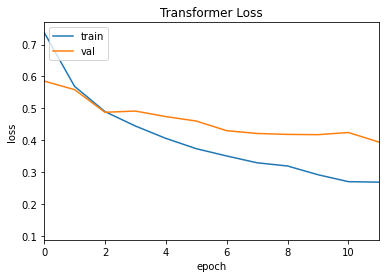

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.xlim(0,11)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Transformer Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Transformer Loss.png", dpi=300)
plt.show()


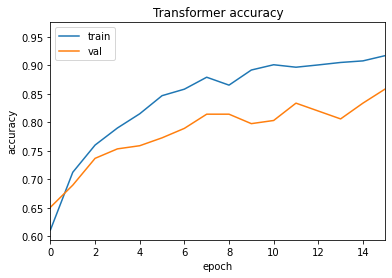

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.xlim(0,15)
plt.plot(history.history['val_binary_accuracy'])
plt.title('Transformer accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Transformer Accuracy.png", dpi=300)
plt.show()
